Stock market prediction is a challenging task. It requires techniques to reduce challenges such as collinearity, non-stationarity and low signal-to-noise ratio.



## Content

* ## Regression Problem
* ### [Feature Engineering](#feature-eng)
* [Feature Selection](#feature-sel)
* [FeatureTools](#feature-tools)
* [Reduce Multicollinearity](#reduce-multicol)


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import technical_indicator as ti
import plotting as pl

from finta import TA

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler,Normalizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import datetime as dt

import featuretools as ft
from boruta import BorutaPy

# Regression Problem

Data Management

**`features`**

Contains all features to be used for prediction. To avoid look-ahead bias, the dataframe only contains values that would have been known at that point in time. I'll explain about look-ahead bias later.

**`outcomes`**

Contains all possible outcomes to be predicted, conviniently shifted back in time. For example, if we wanted to predict the next day return, we would look ahead one day into the future, calculate the metric and record it at time T=0.

This makes it very easy to extract X and y for fitting models and join both dataframes as the rows are already aligned. 

Let's start from downloading the dataset. I used yfinance package to download prices.

Note: Set auto_adjust parameter to True so that the prices are adjusted for splits and dividends. 


In [15]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'SPY']
df = yf.download(tickers, period='10y', auto_adjust=True, group_by='ticker')
df.head(200)

[*********************100%***********************]  4 of 4 completed


AMZN                                               \
                  Open        High         Low       Close   Volume   
Date                                                                  
2011-03-28  171.800003  172.500000  169.250000  169.350006  3400800   
2011-03-29  170.729996  174.839996  170.070007  174.619995  4884600   
2011-03-30  177.779999  181.160004  177.660004  179.419998  6859300   
2011-03-31  179.309998  181.570007  178.500000  180.130005  4826500   
2011-04-01  181.580002  183.250000  178.589996  180.130005  5684100   
...                ...         ...         ...         ...      ...   
2012-01-04  179.210007  180.500000  176.070007  177.509995  4205200   
2012-01-05  175.940002  178.250000  174.050003  177.610001  3809100   
2012-01-06  178.070007  184.649994  177.500000  182.610001  7008400   
2012-01-09  182.759995  184.369995  177.000000  178.559998  5056900   
2012-01-10  181.100006  182.399994  177.100006  179.339996  3985800   

                 MSFT                                                    SPY  \
                 Open       High        Low      Close    Volume        Open   
Date                                                                           
2011-03-28  20.474919  20.522795  20.251498  20.275436  48973200  107.946576   
2011-03-29  20.219578  20.363206  20.187660  20.339268  40763500  107.364089   
2011-03-30  20.427041  20.522792  20.347248  20.435020  41999300  108.742350   
2011-03-31  20.427046  20.490880  20.219584  20.259480  63233700  108.783366   
2011-04-01  20.371196  20.371196  20.195650  20.331299  63114200  109.447882   
...               ...        ...        ...        ...       ...         ...   
2012-01-04  21.839979  22.369284  21.807407  22.312283  80516100  106.081723   
2012-01-05  22.295995  22.581006  22.222708  22.540291  56081400  105.923285   
2012-01-06  22.418144  22.955593  22.418144  22.890448  99455500  106.915704   
2012-01-09  22.841583  22.882300  22.572859  22.589146  59706800  106.748919   
2012-01-10  22.743872  22.923022  22.597295  22.670584  60014400  107.908144   

                                                                AAPL  \
                  High         Low       Close     Volume       Open   
Date                                                                   
2011-03-28  108.225504  107.421528  107.454338  109762400  10.863947   
2011-03-29  108.209087  107.011329  108.176277  129798800  10.695058   
2011-03-30  109.242787  108.586474  108.922836  135835000  10.786730   
2011-03-31  109.078706  108.660300  108.775154  132537100  10.655063   
2011-04-01  109.743222  108.972056  109.234573  153850100  10.801189   
...                ...         ...         ...        ...        ...   
2012-01-04  106.590448  105.673076  106.498711  127186500  12.612821   
2012-01-05  106.940730  105.439577  106.782272  173895000  12.765100   
2012-01-06  106.932387  106.156789  106.507057  148050000  12.913377   
2012-01-09  106.899029  106.256876  106.765602   99530200  13.089651   
2012-01-10  108.124973  107.541192  107.691315  115282000  13.102258   

                                                        
                 High        Low      Close     Volume  
Date                                                    
2011-03-28  10.899940  10.780579  10.780579  309355200  
2011-03-29  10.796576  10.645838  10.796576  352900800  
2011-03-30  10.794114  10.688289  10.724896  329406000  
2011-03-31  10.760888  10.645835  10.721204  274019200  
2011-04-01  10.815955  10.560929  10.599690  418661600  
...               ...        ...        ...        ...  
2012-01-04  12.756793  12.590672  12.718646  260022000  
2012-01-05  12.875846  12.694960  12.859850  271269600  
2012-01-06  13.005051  12.896458  12.994284  318292800  
2012-01-09  13.158867  12.961984  12.973674  394024400  
2012-01-10  13.105027  12.966593  13.020121  258196400  

[200 rows x 20 columns]

Visualising the datasets. I applied log function because Amazon stock were significantly higher, so it is impossible to visualise the prices of all three stocks

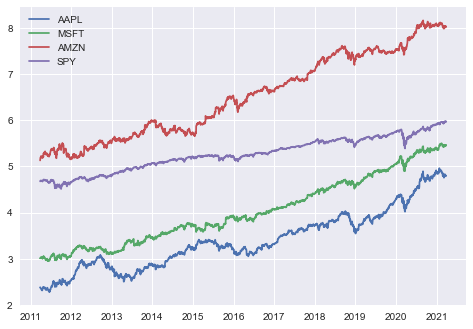

In [16]:
for ticker in tickers:
    plt.plot(df[ticker]['Close'].apply(np.log), label=ticker)
    
plt.legend()
    


# Feature Engineering <a name="feature-eng"></a>

Feature Engineering refers to pre-processing of raw data into a format which is more easily understood by machine learning algorithms. 

I believe it is one of the most important and underappreciated activities in machine learning. 

**Important considerations**

Since we are dealing with time-series data, it is crucial to be aware of potential challenges and biases we may introduce, whether intentially or unintentially.

Look-ahead bias. 

Look-ahead bias occurs when the information or data that is not available in the analysis period is used for a simulation. This can lead to innacurate results which are often overoptimistic. 

False ordinality.

We should also avoid representing features in ordinal way if it has no meaning. For example, it is not the best approach to represent day of a week as an integer from 1 to 7 because we will be telling the model to treat one day differently than the other.



The 5-, 10-, 20- and 50-day moving averages are frequently utilized to identify near-term trend changes.

In [17]:
feature_names = ['daily_return', 'price_diff', 'vol_log']
col_names = pd.MultiIndex.from_product([tickers, feature_names])
features = pd.DataFrame(index=df.index, columns=col_names).sort_index()

for ticker in tickers:
    features.loc[:, (ticker, 'daily_return')] = df[ticker]['Close'] / df[ticker]['Open'] - 1
    features.loc[:, (ticker, 'price_diff')] = df[ticker]['Close'].diff(1)
    features.loc[:, (ticker, 'vol_log')] = df[ticker]['Volume'].apply(np.log)
    features.loc[:, (ticker, 'vol_diff_1')] = df[ticker]['Volume'].diff(1)
    features.loc[:, (ticker, 'vol_diff_50')] = df[ticker]['Volume'].diff(50)
    
    # Rate of change in volume
    features.loc[:, (ticker, 'roc_vol')] = ti.rate_of_change(df[ticker]['Volume'])
    
    for period in [5, 10, 20, 50, 100, 200]:
        
        # Moving average of volume (log)
        features.loc[:, (ticker, 'sma{}_vol'.format(period))] = ti.simple_ma(features[ticker]['vol_log'], period=period)
        
        # Closing price vs n-day EMA 
        features.loc[:, (ticker, 'close_vs_ema{}'.format(period))] = df[ticker]['Close'] / ti.exp_ma(df[ticker]['Close'], period=period) - 1
         
        # Daily Volume vs. n-day SMA
        features.loc[:, (ticker, 'vol_vs_sma{}'.format(period))] = df[ticker]['Volume'] / ti.simple_ma(df[ticker]['Volume'], period=period) - 1
    
    # Average True Range (14-day)
    features.loc[:, (ticker, 'atr')] = ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])
    
    # High divided by Average True Range with window of 10
    features.loc[:, (ticker, 'high10atr')] = df[ticker]['High'] / ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'], period=10)
       
    # Relative Strengh Index (RSI)
    features.loc[:, (ticker, 'RSI')] = ti.RSI(df[ticker]['Close'])
    
    # Money Flow Index (MFI)
    features.loc[:, (ticker, 'MFI')] = ti.money_flow_index(df[ticker]['Volume'], df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])

    # Stochastic Oscillator
    features.loc[:, (ticker, 'STOCH')] = ti.stochastic_oscillator(df[ticker]['Close'], df[ticker]['High'], df[ticker]['Low'])
    
    # Moving Average Convergence Divergence (MACD)
    features.loc[:, (ticker, 'MACD')] = ti.MACD(df[ticker]['Close']).iloc[:, 0]
    features.loc[:, (ticker, 'MACD_signal')] = ti.MACD(df[ticker]['Close']).iloc[:, 1]

    # Accumulation/Distribution
    features.loc[:, (ticker, 'ADI')] = ti.accumulation_distribution(df[ticker]['Close'], df[ticker]['Low'], df[ticker]['High'], df[ticker]['Volume'])

outcome_names = ['target_close_5']
col_names_out = pd.MultiIndex.from_product([tickers, outcome_names])
outcomes = pd.DataFrame(index=df.index, columns=col_names_out).sort_index()

for ticker in tickers:
    # Change in closing price in the next 5 days
    outcomes.loc[:, (ticker, 'target_close_1')] = df[ticker]['Close'].pct_change(-1)
    outcomes.loc[:, (ticker, 'target_close_5')] = df[ticker]['Close'].pct_change(-5)
    outcomes.loc[:, (ticker, 'target_close_10')] = df[ticker]['Close'].pct_change(-10)
    

In [18]:
df_new = features.join(outcomes)
df_new = df_new.dropna()

## Feature Selection <a name="feature-sel"></a>


### Normalizing data

Before diving into evaluation of the features for predictive strength, we will standardize data given that we have data of different scales.

For that, we can use StandardScaler() method as part of scikit-learn package.

In [19]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, index=df.index)
df_scaled.columns = df.columns


<AxesSubplot:title={'center':'Strength of Correlation'}>

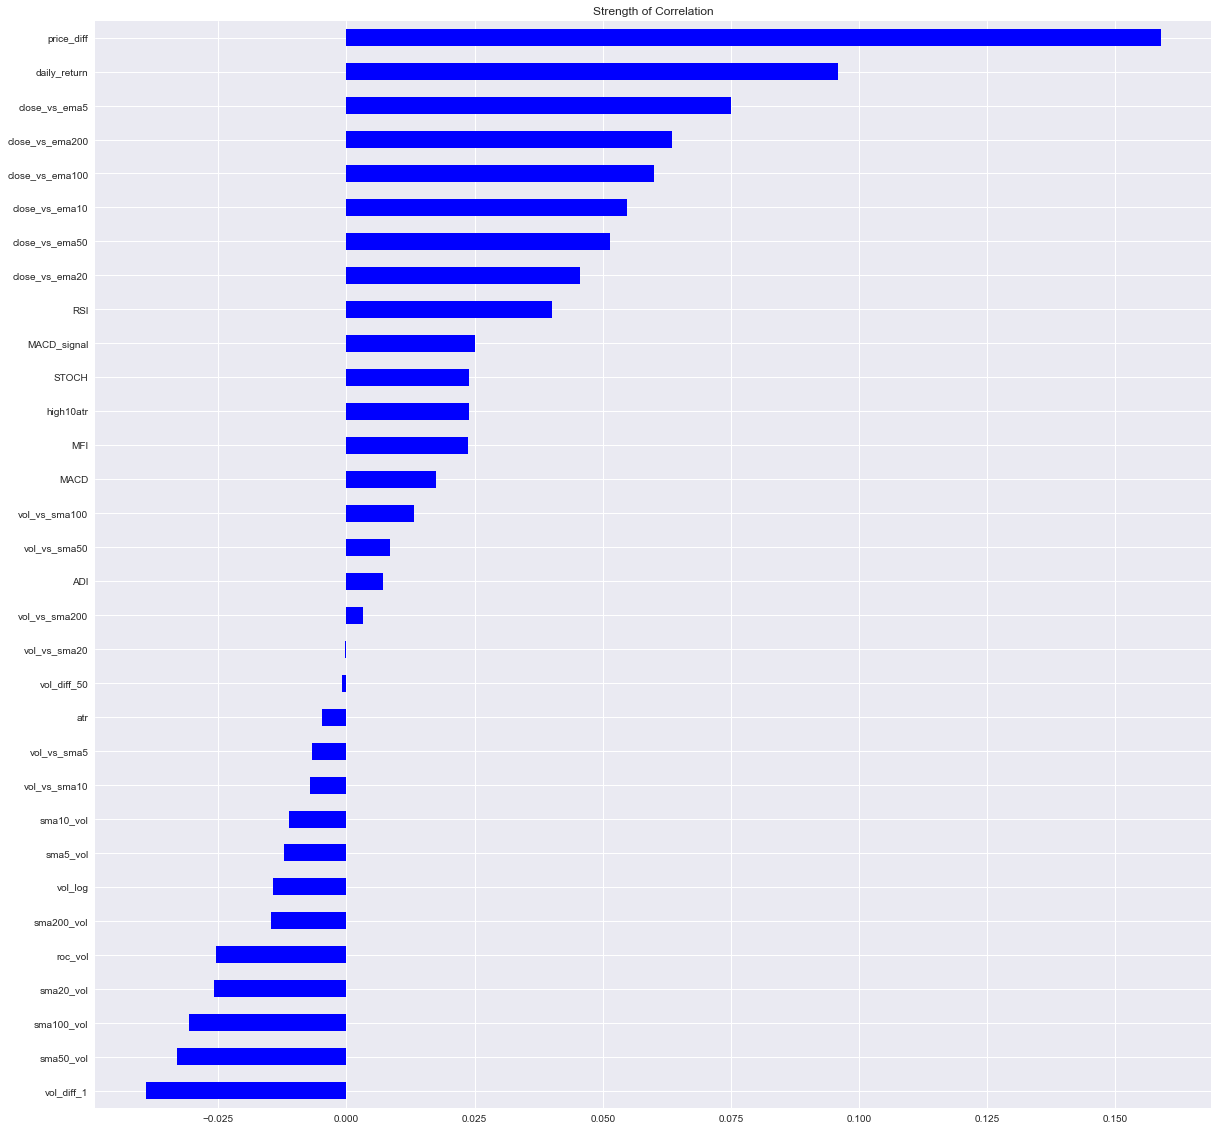

In [20]:
# Correlation strength
plt.style.use('seaborn')
plt.figure(figsize=(20,20))

corr = features['SPY'].corrwith(df_new['SPY']['target_close_1'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')


Even though correlation is not the ideal metric, it should give us an idea of strengh of each feature's relationship to the target variable.

However, it gives us no information about multicollinearity. 

We can leverage seaborn's clustermap chart that plots a heatmap representation of a covariance matrix.

It is important to note that scaling the features before runtime is a form of data leakage (I mentioned look-ahead bias earlier). However, for the purpose of EDA and to understand better the feature set, it can be justified.
Of course, we will not be using these scaled features and it comes to model training and testing as this would not be available at that time.



In [21]:
feats_max_corr = corr[corr > 0.02].index
corr.sort_values(ascending=False)

price_diff         0.158830
daily_return       0.095909
close_vs_ema5      0.075020
close_vs_ema200    0.063540
close_vs_ema100    0.060015
close_vs_ema10     0.054696
close_vs_ema50     0.051400
close_vs_ema20     0.045642
RSI                0.040068
MACD_signal        0.025022
STOCH              0.023900
high10atr          0.023821
MFI                0.023703
MACD               0.017503
vol_vs_sma100      0.013208
vol_vs_sma50       0.008453
ADI                0.007170
vol_vs_sma200      0.003237
vol_vs_sma20      -0.000248
vol_diff_50       -0.000811
atr               -0.004788
vol_vs_sma5       -0.006800
vol_vs_sma10      -0.007077
sma10_vol         -0.011222
sma5_vol          -0.012269
vol_log           -0.014297
sma200_vol        -0.014675
roc_vol           -0.025515
sma20_vol         -0.025876
sma100_vol        -0.030638
sma50_vol         -0.033097
vol_diff_1        -0.039058
dtype: float64

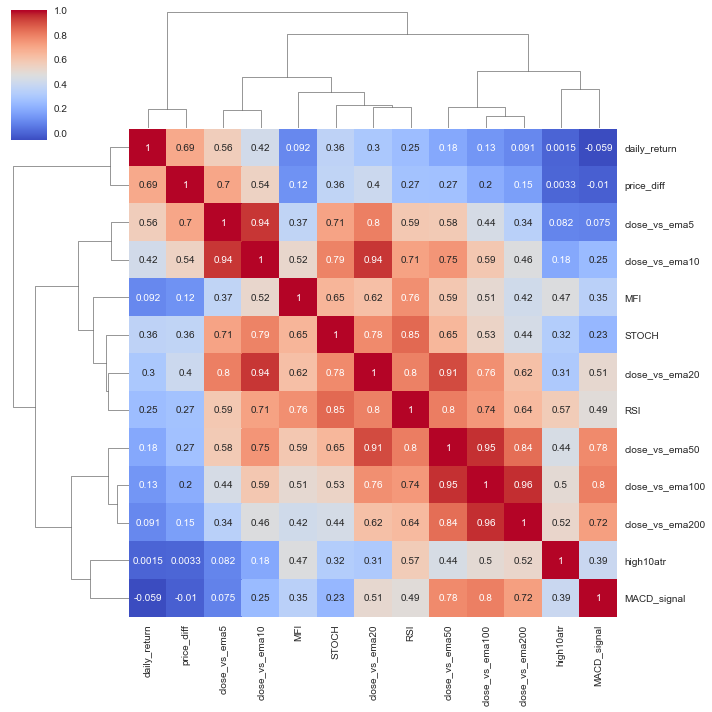

In [22]:
sns.clustermap(features['SPY'][feats_max_corr].corr(), cmap='coolwarm', annot=True, method='ward')

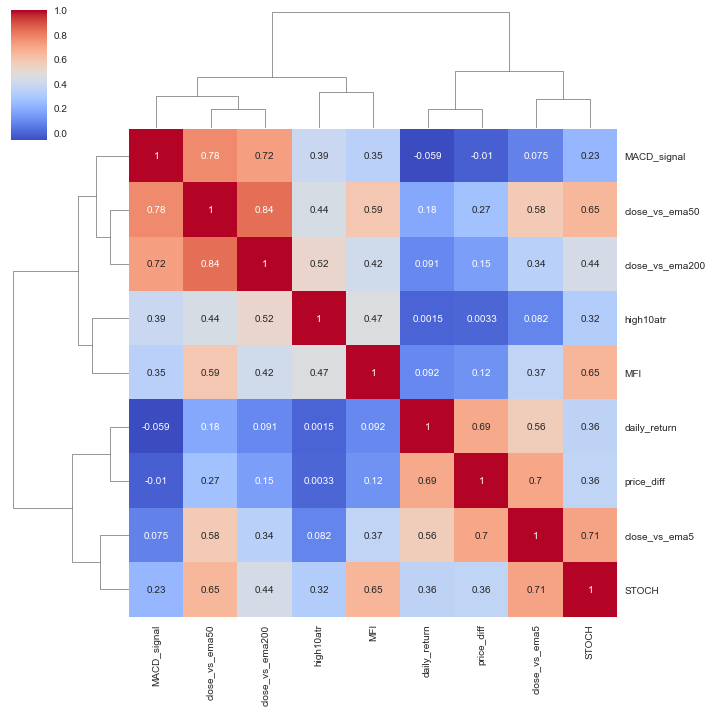

In [26]:
feats_selected = feats_max_corr.drop(['close_vs_ema10', 'close_vs_ema100', 'close_vs_ema20', 'RSI'])
sns.clustermap(features['SPY'][feats_selected].corr(), cmap='coolwarm', annot=True, method='ward')


In [35]:
features_selected = df_new['SPY'][feats_selected]
df_SPY = df_new['SPY'].loc[:, features_selected.columns]

df_SPY = df_SPY.join(df_new['SPY']['target_close_1'])
df_SPY

,daily_return,price_diff,close_vs_ema5,close_vs_ema50,close_vs_ema200,high10atr,MFI,STOCH,MACD_signal,target_close_1
Date,,,,,,,,,,
2012-01-10,-0.002009,0.925713,0.008220,0.041837,0.047025,93.139597,87.097585,94.396675,0.982172,-0.000542
2012-01-11,0.003651,0.058365,0.005827,0.040671,0.047020,92.341480,80.033910,93.478174,1.052236,-0.002394
2012-01-12,-0.000463,0.258522,0.005479,0.041404,0.048936,97.008489,79.245765,96.526454,1.119060,0.005200
2012-01-13,0.001555,-0.558762,0.000185,0.034555,0.042990,93.923072,69.834158,82.696060,1.168885,-0.003866
2012-01-17,-0.005689,0.416977,0.002707,0.037001,0.046474,90.563113,70.546197,82.468384,1.209431,-0.010935
...,...,...,...,...,...,...,...,...,...,...
2021-03-08,-0.007643,-1.903778,-0.001575,0.004652,0.090688,45.711585,41.032920,47.353181,1.359873,-0.014077
2021-03-09,0.003421,5.432220,0.008418,0.018238,0.105092,46.280113,46.740720,74.585414,1.135716,-0.006186
2021-03-10,-0.000282,2.402130,0.009749,0.023589,0.110733,48.012764,52.160846,86.341502,1.031874,-0.010037


Calculating from 2012-01-10 00:00:00 to 2012-03-31 00:00:00
Calculating from 2012-03-31 00:00:00 to 2012-06-30 00:00:00
Calculating from 2012-06-30 00:00:00 to 2012-09-30 00:00:00
Calculating from 2012-09-30 00:00:00 to 2012-12-31 00:00:00
Calculating from 2012-12-31 00:00:00 to 2013-03-31 00:00:00
Calculating from 2013-03-31 00:00:00 to 2013-06-30 00:00:00
Calculating from 2013-06-30 00:00:00 to 2013-09-30 00:00:00
Calculating from 2013-09-30 00:00:00 to 2013-12-31 00:00:00
Calculating from 2013-12-31 00:00:00 to 2014-03-31 00:00:00
Calculating from 2014-03-31 00:00:00 to 2014-06-30 00:00:00
Calculating from 2014-06-30 00:00:00 to 2014-09-30 00:00:00
Calculating from 2014-09-30 00:00:00 to 2014-12-31 00:00:00
Calculating from 2014-12-31 00:00:00 to 2015-03-31 00:00:00
Calculating from 2015-03-31 00:00:00 to 2015-06-30 00:00:00
Calculating from 2015-06-30 00:00:00 to 2015-09-30 00:00:00
Calculating from 2015-09-30 00:00:00 to 2015-12-31 00:00:00
Calculating from 2015-12-31 00:00:00 to 

<AxesSubplot:title={'center':'Correlation of features with target variable (by quarter)'}, xlabel='Date'>

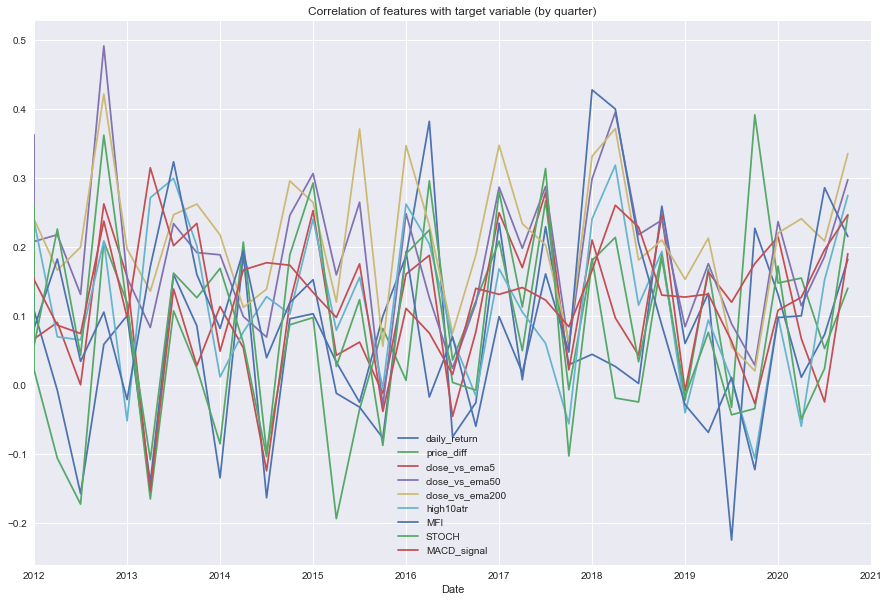

In [144]:

recalc_dates = df_SPY.resample('Q').mean().index
recalc_dates = recalc_dates.insert(item=min(df_SPY.index), loc=0) # Add starting date
corrs = pd.DataFrame(index=recalc_dates, columns=features_selected.columns)
for i, date in enumerate(recalc_dates):
    try:
        print("Calculating from {} to {}".format(recalc_dates[i], recalc_dates[i+1]))
        corr = features_selected.loc[recalc_dates[i]:recalc_dates[i+1]].corrwith(df_SPY.loc[recalc_dates[i]:recalc_dates[i+1]]['target_close_1'])
        corrs.loc[date, :] = corr

    except:
        break
        
corrs.plot(title='Correlation of features with target variable (by quarter)', figsize=(15,10))

In [146]:
features_selected

,daily_return,price_diff,close_vs_ema5,close_vs_ema50,close_vs_ema200,high10atr,MFI,STOCH,MACD_signal
Date,,,,,,,,,
2012-01-10,-0.002009,0.925713,0.008220,0.041837,0.047025,93.139597,87.097585,94.396675,0.982172
2012-01-11,0.003651,0.058365,0.005827,0.040671,0.047020,92.341480,80.033910,93.478174,1.052236
2012-01-12,-0.000463,0.258522,0.005479,0.041404,0.048936,97.008489,79.245765,96.526454,1.119060
2012-01-13,0.001555,-0.558762,0.000185,0.034555,0.042990,93.923072,69.834158,82.696060,1.168885
2012-01-17,-0.005689,0.416977,0.002707,0.037001,0.046474,90.563113,70.546197,82.468384,1.209431
...,...,...,...,...,...,...,...,...,...
2021-03-08,-0.007643,-1.903778,-0.001575,0.004652,0.090688,45.711585,41.032920,47.353181,1.359873
2021-03-09,0.003421,5.432220,0.008418,0.018238,0.105092,46.280113,46.740720,74.585414,1.135716
2021-03-10,-0.000282,2.402130,0.009749,0.023589,0.110733,48.012764,52.160846,86.341502,1.031874


### Splitting data and re-scaling

Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [ ]:
split_point = int(0.80*len(df))

train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]

standard_scaler.fit_transform(df_SPY)

X_train = features_selected.iloc[:split_point,:] 
y_train = df['AAPL']['target_close_1'].iloc[:split_point] 
X_test = features_selected.iloc[split_point:,:] 
y_test = df['AAPL']['target_close_1'].iloc[split_point:]

X_train = standard_scaler.fit_transform(X_train)
y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
X_test = standard_scaler.fit_transform(X_test)
y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))

model = LinearRegression()
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(model.score(X=X_train,y=y_train)))
print('RSQ out of sample: '+str(model.score(X=X_test,y=y_test)))
print('Regression Coefficients: '+str(model.coef_))


In [149]:
split_point = int(0.80*len(df))
train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]
train_dataset


,daily_return,price_diff,close_vs_ema5,close_vs_ema50,close_vs_ema200,high10atr,MFI,STOCH,MACD_signal,target_close_1
Date,,,,,,,,,,
2012-01-10,-0.002009,0.925713,0.008220,0.041837,0.047025,93.139597,87.097585,94.396675,0.982172,-0.000542
2012-01-11,0.003651,0.058365,0.005827,0.040671,0.047020,92.341480,80.033910,93.478174,1.052236,-0.002394
2012-01-12,-0.000463,0.258522,0.005479,0.041404,0.048936,97.008489,79.245765,96.526454,1.119060,0.005200
2012-01-13,0.001555,-0.558762,0.000185,0.034555,0.042990,93.923072,69.834158,82.696060,1.168885,-0.003866
2012-01-17,-0.005689,0.416977,0.002707,0.037001,0.046474,90.563113,70.546197,82.468384,1.209431,-0.010935
...,...,...,...,...,...,...,...,...,...,...
2020-01-03,0.003892,-2.406982,-0.000570,0.032723,0.090778,160.195259,77.035257,76.190920,3.475135,-0.003801
2020-01-06,0.009829,1.203522,0.002159,0.035174,0.093906,146.351772,76.394859,86.401761,3.479188,0.002820
2020-01-07,-0.000898,-0.890411,-0.000439,0.030959,0.089845,154.952049,75.224134,69.023801,3.453041,-0.005301


As we can see, this results in a terrible fit. We could not predict the target value at all. For out-of-sample dataset, we got negative R2 which means that the chosen model does not follow the trend of the data, so fits worse than a horizontal line.


## Walk-Forward approach

Is there a better approach?

Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [ ]:
recalc_dates = features_selected.resample('Q').mean().index

models = pd.Series(index=recalc_dates, dtype='object')
for date in recalc_dates:
    X_train = df['AAPL'].loc[:date, features_selected.columns]
    y_train = df['AAPL']['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    
    print("Training on the first {} records, from {} to {}".
          format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    print("Coefficients: {}".format((model.coef_)))


In [ ]:
def build_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_[0],index=features_selected.columns.values)
        model_coefs.name = models.index[i]
        coefs = pd.concat([coefs,model_coefs],axis=1)
    return coefs.T

build_coefs(models).plot(title='Coefficients for Expanding Window Model')

In [ ]:
features_selected.columns

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(y_test, label='Actual')
plt.plot(X_test.index, pred, label='Predicted')
# plt.plot(X_test.index, X_test['DAILY_RETURN'], label='Daily return')
plt.legend()
plt.show()

# XGBoost Regressor

In [ ]:
X = features_scaled['AAPL']
Y = outcome_scaled['AAPL']['close_10']

tmp = X.join(Y).dropna()
X, Y = tmp.iloc[:, :-1], tmp.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, shuffle=False)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)
print('RSQ test {}'.format(r2_score(y_test, pred)))

plt.figure(figsize=(20,10))

plt.plot(y_test, label='Actual')
plt.plot(X_test.index, pred, label='Predicted')
plt.legend()
plt.show()

# XGBoost Classifier

## Transformation

In [ ]:
outcome_names_classification = ['BUY', 'SELL', 'HOLD']

col_names_out = pd.MultiIndex.from_product([tickers, outcome_names_classification])
outcome_classification = pd.DataFrame(index=df.index, columns=col_names_out).sort_index()

for ticker in tickers:
    outcome_classification.loc[outcomes[outcomes[ticker]['close_1'] > .003].index, (ticker, 'BUY')] = 1
    outcome_classification.loc[outcomes[outcomes[ticker]['close_1'] < -.003].index, (ticker, 'SELL')] = 1
    outcome_classification.loc[outcome_classification['AAPL'][['BUY', 'SELL']].isnull().sum(axis=1) == 2, (ticker, 'HOLD')] = 1

outcome_classification = outcome_classification.fillna(0)

## Modelling

In [ ]:
X = features['AAPL']
Y = outcome_classification['AAPL']['BUY']

tmp = X.join(Y).dropna()
X, Y = tmp.iloc[:, :-1], tmp.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, shuffle=False)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)

print('Accuracy test {}'.format(accuracy_score(y_test, pred)))
print('Accuracy train {}'.format(xgb_model.score(X=X_train,y=y_train)))
print('f-score {}'.format(f_score))


In [ ]:
X = features['AAPL']
Y = outcome_classification['AAPL']['BUY']
Y

## Feature Engineering - Technical Indicators

In [ ]:
# Daily return in percentage
df['DAILY_RETURN'] = ti.daily_return(df['Close'])

# Rate of change in volume
df['ROC'] = ti.rate_of_change(df['Volume'])

# Price difference
df['DIFF'] = ti.price_diff(df['Close'])

# Bollinger Bands
df[['BB_MID', 'BB_UPPER', 'BB_LOWER']] = ti.bollinger_bands(df['Close'])

# Relative Strengh Index (RSI)
df['RSI'] = ti.RSI(df['Close'])

# Moving Average Convergence Divergence (MACD)
df[['MACD', 'MACD_signal']] = ti.MACD(df['Close'])

# Stochastic Oscillator
df['STOCH'] = ti.stochastic_oscillator(df['Close'], df['High'], df['Low'])

# Accumulation/Distribution
df['ADI'] = ti.accumulation_distribution(df['Close'], df['Low'], df['High'], df['Volume'])

# Average True Range
df['ATR'] = ti.average_true_range(df['High'], df['Low'], df['Close'])

# Vortex
df[['VI_up', 'VI_down']] = ti.vortex(df['High'], df['Low'], df['Close'])

# Ease of Movement
df['EMV'] = ti.ease_of_movement(df['High'], df['Low'], df['Volume'])

# Commodity Channel Index
df['CCI'] = ti.commodity_channel(df['High'], df['Low'], df['Close'])

# On-Balance Volume
df['OBV'] = ti.on_balance_volume(df['Close'], df['Volume'])



Visualise daily return, rate of change and z-scores

In [ ]:
plt.figure(figsize=(20,10))

sns.histplot(df['DAILY_RETURN'], kde=True)
plt.show()

sns.histplot(df['ROC'], kde=True)
plt.show()




## Stock movement
Label column:

1 if daily return is > threshold

-1 if daily return is < threshold


In [ ]:
threshold = 0

df.loc[:, 'BUY_SIGNAL'] = 0
df.loc[:, 'SELL_SIGNAL'] = 0

df.loc[df['DAILY_RETURN'].shift(-1) > threshold, 'BUY_SIGNAL'] = 1
df.loc[df['DAILY_RETURN'].shift(-1) < -threshold, 'SELL_SIGNAL'] = 1

# Drop NaN values
df = df.dropna()

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(X_train.index, X_train['DAILY_RETURN'], linewidth=1, label='Train data')
plt.plot(X_test.index, X_test['DAILY_RETURN'], linewidth=1, label='Data to predict')
plt.axhline(y=.0025, linewidth=1, color='g', linestyle='--', label='Threshold for buy signal')
plt.axhline(y=-.0025, linewidth=1, color='b', linestyle='--', label='Threshold for sell signal')

plt.legend()
plt.show()


In [ ]:
## Plot bollinger bands

plt.style.use('fivethirtyeight')

# Bollinger bands
plt.figure(figsize=(20,15))
plt.plot(df['Adj Close'], label='Adj Close', linewidth=1)
plt.fill_between(df['Adj Close'].index, df['BB_UPPER'], df['BB_LOWER'], alpha=.2)
plt.plot(df['BB_UPPER'], label='Upper band', linestyle='dashed', linewidth=2)
plt.plot(df['BB_LOWER'], label='Lower band', linestyle='dashed', linewidth=2)
plt.plot(df['BB_MID'], label='20-day simple moving average', linewidth=2)
plt.title('Bollinger bands')
plt.legend(fontsize=15)

plt.show()


In [ ]:
# Add moving averages for multiple periods
for period in [5, 10, 20, 50, 100, 200]:
    df['SMA{}'.format(str(period))] = ti.simple_ma(df['Adj Close'], length=period)
    df['EMA{}'.format(str(period))] = ti.exp_ma(df['Adj Close'], length=period)
    

### Features to be considered:
`1`. **Moving Averages**

We'll be using moving averages (both simple and exponential) to construct other features.




`4`. Daily return

Percent change between closing price and opening price

`    features.loc[:, (ticker, 'DAILY_RETURN')] = df[ticker]['Close'] / df[ticker]['Open'] - 1
`

`5`. Log volume

Volume transformed to log scale.

`6`. Rate of change

Percent change. We can use pandas handy method pct_change()

`7`. Price difference

## Technical Indicators

`3`. Bollinger Bands

`9`. Relative Strengh Index (RSI)
Measures the magnitude of recent price changes. Commonly used in technical analysis to evaluate overbought or oversold conditions in the price of a stock.
This indicator was developed by J.Welles Wilder Jr.
According to this indicator, a stock is considered overbought when the RSI is above 70% and oversold when it is below 30%.

`10`. Moving Average Convergence Divergence (MACD)
MACD is a trend-following momentum indicator that demonstrates the relationship between two moving averages - long-term and short-term. MACD is calculated as 

MACD = EMA(26-period) - EMA(12-period)

MACD is often used together with Relative Strength (RSI) to show a more complete picture of a market.

The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.

`11`. Stochastic Oscillator

The Stochastic Oscillator is a momentum indicator that compares a specific closing price of a security to its high-low range over a certain period of time. First developed in the 1950s, it is a popular momentum indicator to identify overbought and oversold conditions of an asset. 
	  
`12`. Accumulation/Distribution Indicator (A/D)

`13`. Average True Range(ATR)
ATR is a market volatility indicator. Introduced by market technician J.Welles Wilder Jr., this indicator measures market volatility by decomposing the complete range of a security price for that period.

`14`. Vortex Indicator
The Vortex Indicator consists of two oscillating lines: one to capture the upward trend movement and the other one to identify the downward price movement.

`15`. Ease of Movement

`16`. Commodity Channel Index (CCI)
A momentum-based oscillator used to identify an asset that is reaching a condition of being oversold or overbought.

`17`. On-Balance Volume (OBV)
A momentum-based indicator using volume flow to predict changes in asset price. First developed by Joseph Granville, he believed that the volume was the major force behind markets. As explained in his 1963 book Granville's New Key to Stock Market Profits, when volume increases strongly without a signficant change in the price of an asset, the price will eventually jump upwards or downwards. Granville theorised that volume precedes price. 

__How to interpret.__

We should expect prices to increase if OBV is rising while prices are either flat or moving down, and vice versa.


# References

https://www.investopedia.com/terms/r/rsi.asp

https://www.investopedia.com/terms/m/macd.asp

https://altfins.com/knowledge-base/macd-line-and-macd-signal-line/

https://www.investopedia.com/terms/s/stochasticoscillator.asp

https://www.investopedia.com/terms/a/accumulationdistribution.asp

https://www.investopedia.com/terms/a/atr.asp

https://www.investopedia.com/articles/active-trading/072115/understand-vortex-indicator-trading-strategies.asp

https://www.investopedia.com/terms/e/easeofmovement.asp

https://www.investopedia.com/terms/c/commoditychannelindex.asp

https://www.investopedia.com/terms/o/onbalancevolume.asp

https://www.investopedia.com/terms/m/mfi.asp

https://www.investopedia.com/terms/l/lookaheadbias.asp

